### Implementing Shor’s Algorithm End-to-End:  
## From Classical Order Finding to Real IBM Quantum Hardware  
By Carlos Araque L.
Data Engineer , IBM Qiskit Advocate
Melbourne, Australia


In [1]:

# Librry check script
import importlib

def check_package(pkg_name):
    try:
        importlib.import_module(pkg_name)
        print(f"✓ '{pkg_name}' está instalado.")
        return True
    except ImportError:
        print(f"✗ '{pkg_name}' NO está instalado.")
        return False


# Lista de librerías a validar
paquetes = [
    "requests",
    "qiskit",
    "qiskit_aer",           # nombre correcto para importar
    "qiskit_ibm_runtime",   # nombre correcto para importar
    "matplotlib"
]

# Validación
for pkg in paquetes:
    check_package(pkg)


✓ 'requests' está instalado.
✓ 'qiskit' está instalado.
✓ 'qiskit_aer' está instalado.
✓ 'qiskit_ibm_runtime' está instalado.
✓ 'matplotlib' está instalado.


Celda 1 — Imports + helpers clásicos (orden → factores)

In [2]:
from math import gcd
from fractions import Fraction

def recover_order_from_measurement(bitstring: str, t: int, a: int, N: int, max_den: int = 256):
    """
    bitstring (fase) -> y -> y/2^t ≈ k/r -> fracciones continuas -> validar r con pow(a, r, N)==1
    """
    y = int(bitstring, 2)
    phase = y / (2**t)
    frac = Fraction(phase).limit_denominator(max_den)

    candidates = [frac.denominator] + [frac.denominator*m for m in range(2, 9)]

    for r in candidates:
        if r > 1 and pow(a, r, N) == 1:
            return r, y, phase, frac
    return None, y, phase, frac


def shor_postprocess(a: int, N: int, r: int):
    """
    Si r es par y a^(r/2) != -1 mod N, saca factores con gcd.
    """
    if r is None or r % 2 != 0:
        return None

    x = pow(a, r // 2, N)
    if x == N - 1:
        return None

    p = gcd(x - 1, N)
    q = gcd(x + 1, N)
    if 1 < p < N and 1 < q < N:
        return (p, q)
    return None


Celda 2 — Parámetros del demo (N=15) + sanity check

In [3]:
N = 15
a = 2

print("N =", N, "a =", a)
print("gcd(a, N) =", gcd(a, N))
# Debe dar 1 (si no, ya tienes factor directo).

N = 15 a = 2
gcd(a, N) = 1


Celda 3 — Construir el unitario U(a): multiplicación modular como permutación

Para N=15 usamos n=4 qubits (16 estados). Definimos:

si y < 15: y -> (a*y) mod 15

si y == 15: lo dejamos fijo

In [4]:
import numpy as np
from qiskit.circuit.library import UnitaryGate

def make_U_mul_mod_N(a: int, N: int, n: int) -> UnitaryGate:
    dim = 2**n
    U = np.zeros((dim, dim), dtype=complex)
    for y in range(dim):
        y2 = (a * y) % N if y < N else y
        U[y2, y] = 1.0
    return UnitaryGate(U, label=f"U_mul_{a}_mod_{N}")

n = 4
U = make_U_mul_mod_N(a, N, n)
print("Unitary dim:", 2**n, "x", 2**n)


Unitary dim: 16 x 16


Celda 4 — Construir QPE (order finding) con iQFT

Recomendación hardware: empieza con t=6 o t=7 para reducir profundidad.

C:\Users\caraq\AppData\Local\Temp\ipykernel_25684\459924058.py:19: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(t, inverse=True, do_swaps=True).to_gate(label="iQFT"), q_phase)


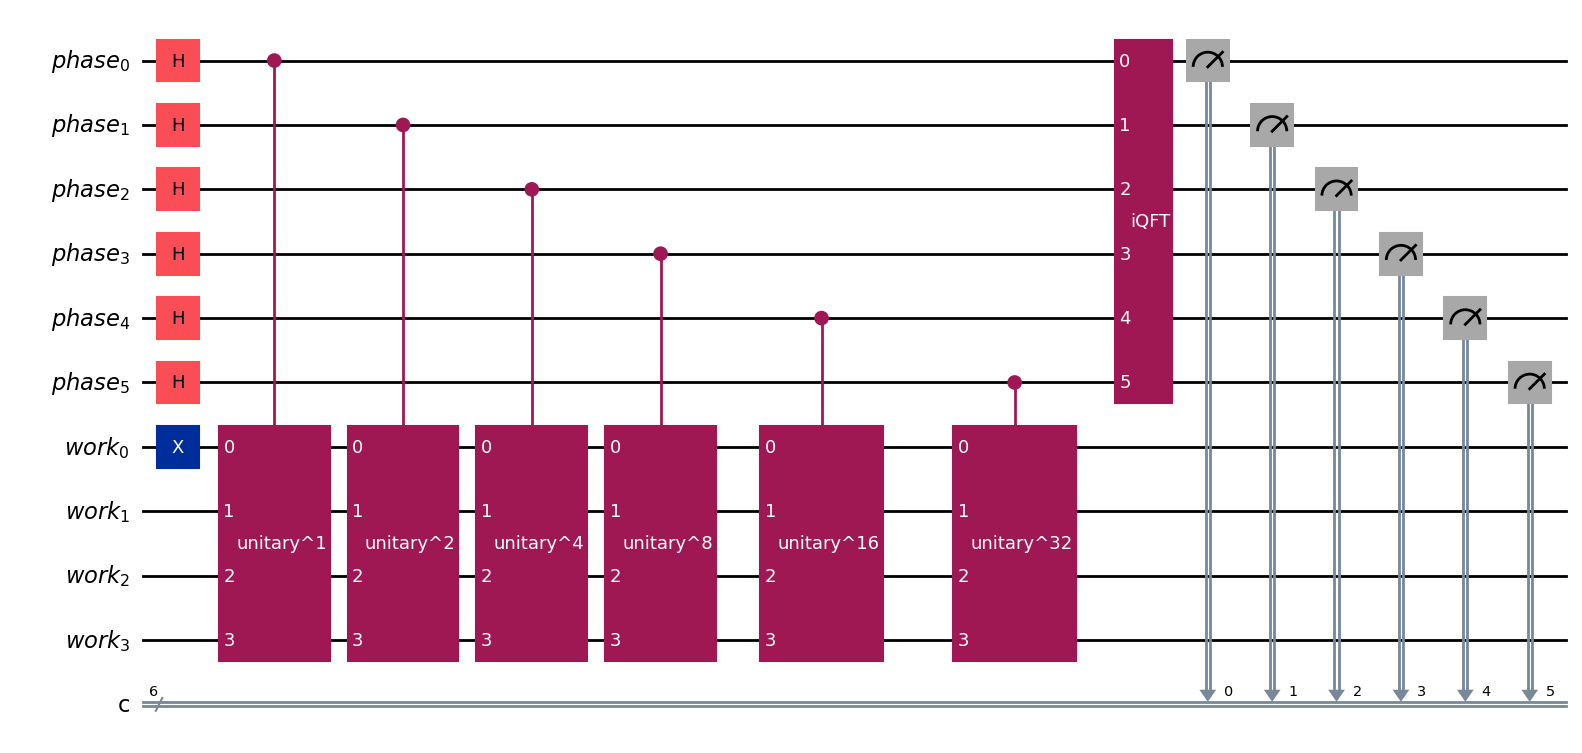

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT

def build_qpe_order_finding(a: int, N: int, t: int, n: int) -> QuantumCircuit:
    q_phase = QuantumRegister(t, "phase")
    q_work = QuantumRegister(n, "work")
    c_phase = ClassicalRegister(t, "c")
    qc = QuantumCircuit(q_phase, q_work, c_phase)

    qc.h(q_phase)          # superposición
    qc.x(q_work[0])        # |work> = |1>

    U = make_U_mul_mod_N(a, N, n)

    # controlled-U^(2^j)
    for j in range(t):
        qc.append(U.power(2**j).control(1), [q_phase[j]] + list(q_work))

    qc.append(QFT(t, inverse=True, do_swaps=True).to_gate(label="iQFT"), q_phase)
    qc.measure(q_phase, c_phase)

    return qc

t = 6
qc = build_qpe_order_finding(a, N, t, n)
qc.draw("mpl")


Celda 5 — (Opcional pero recomendado) Test rápido “modo local” con Aer

Esto no es tu notebook de Aer, pero sirve para verificar que el circuito sigue bien.

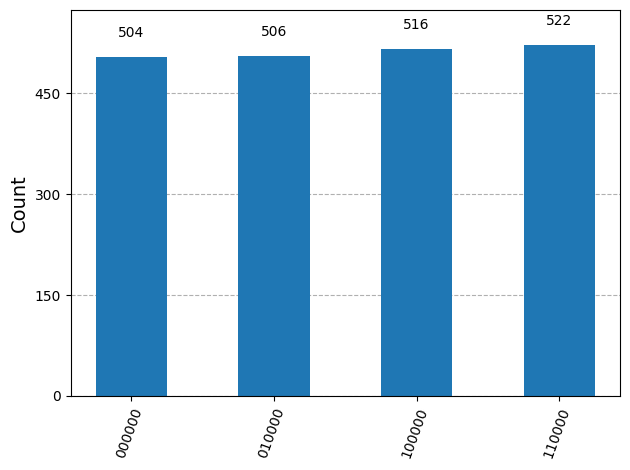

In [6]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

shots_local = 2048
backend_local = AerSimulator()

tqc_local = transpile(qc, backend_local, optimization_level=1)
res_local = backend_local.run(tqc_local, shots=shots_local).result()
counts_local = res_local.get_counts()

plot_histogram(counts_local)


Sección IBM Hardware
Celda 6 — Login / Token (solo si hace falta)

Si ya tienes cuenta guardada, puedes saltarte esto.

Dos opciones comunes:

Opción A: Guardar token una vez (persistente)

In [ ]:

my_api_key ="XXX"
my_crn = "WCEGTWERYEGT-YOUR-CRN"

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=my_api_key,
    instance=my_crn,
    name="name-your-instance",
    overwrite=True
)
#service = QiskitRuntimeService(channel="ibm_quantum_platform")

Celda 7 — Elegir backend real (least_busy) con qubits suficientes

Necesitas al menos t + n qubits (fase + work). Con t=6, n=4 → 10 qubits.

In [12]:
min_qubits = t + n
print("Qubits requeridos:", min_qubits)

backend = service.least_busy(operational=True, simulator=False, min_num_qubits=min_qubits)
print("✅ Backend elegido:", backend.name)


Qubits requeridos: 10
✅ Backend elegido: ibm_torino


Celda 8 — Transpilar para el backend (preset pass manager)

IBM recomienda el enfoque con generate_preset_pass_manager 
IBM Quantum
+1

In [13]:
from qiskit.transpiler import generate_preset_pass_manager

opt_level = 1  # 1 o 2 suele ser razonable para hardware
pm = generate_preset_pass_manager(backend=backend, optimization_level=opt_level)

isa_qc = pm.run(qc)

print("✅ Transpilado listo.")
print("Depth (aprox):", isa_qc.depth())
print("2q gates (aprox):", isa_qc.count_ops().get("cx", 0))
#Si la profundidad se ve muy alta, baja t (por ejemplo t=5).

✅ Transpilado listo.
Depth (aprox): 3389
2q gates (aprox): 0


Celda 9 — Ejecutar en hardware con SamplerV2 + Session

SamplerV2 y Session son el patrón recomendado

In [ ]:
# leave here as example , but  done use,  dot going to run with current credencials
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import SamplerV2 as Sampler

shots_hw = 4000

with Session(backend=backend) as session:
    sampler = Sampler(mode=session)
    job = sampler.run([isa_qc], shots=shots_hw)
    result = job.result()

pub = result[0]
print("✅ Job completado.")

##
“You are not authorized to run a session when using the open plan.” (código 1352)

Eso es exactamente lo que documenta IBM: en el Open Plan (gratis) NO puedes usar Session. En ese plan solo puedes ejecutar en job mode o batch mode. 
IBM Quantum
+2
IBM Quantum
+2

La solución: no uses Session(...).
Usa SamplerV2 en job mode, pasando directamente el backend como mode # 


Esto es la corrección clave: Sampler(mode=backend) en lugar de Sampler(mode=session)

In [ ]:
# Esto es la corrección clave: Sampler(mode=backend) en lugar de Sampler(mode=session)
from qiskit_ibm_runtime import SamplerV2 as Sampler

shots_hw = 4000

# Open Plan: NO Session. Usa el backend como "mode" (job mode).
sampler = Sampler(mode=backend)

job = sampler.run([isa_qc], shots=shots_hw)
result = job.result()

pub = result[0]
print("✅ Job completado (job mode, sin Session).")
#Si la profundidad se ve muy alta, baja t (por ejemplo t=5).


✅ Job completado (job mode, sin Session).


Celda 10 — Obtener counts del resultado (¡importante!)

En SamplerV2, los counts suelen venir por nombre del registro clásico (en nuestro circuito es "c"), usando pub.data.<reg>.get_counts().

Esto coincide con la práctica descrita por la comunidad y cómo se expone BitArray.get_counts()

In [16]:
# En nuestro circuito usamos ClassicalRegister(t, "c")
counts_hw = pub.data.c.get_counts()

top_hw = sorted(counts_hw.items(), key=lambda kv: kv[1], reverse=True)
print("Top 10 outcomes (hardware):")
for s, c in top_hw[:10]:
    print(s, c)


Top 10 outcomes (hardware):
100000 536
010000 520
000000 503
110000 489
100010 113
000010 90
010010 90
100100 80
110010 74
010100 62


Celda 11 — Recuperar r desde hardware + factorizar N

In [17]:
found = None
for bitstring, c in top_hw[:30]:
    r, y, phase, frac = recover_order_from_measurement(bitstring, t, a, N)
    if r is not None:
        found = (bitstring, c, r, y, phase, frac)
        break

print("Recovered:", found)

if found is None:
    print("❌ No se recuperó r. Sugerencias: subir shots, bajar t, o cambiar backend.")
else:
    bitstring, c, r, y, phase, frac = found
    factors = shor_postprocess(a, N, r)

    print(f"bitstring={bitstring}, count={c}")
    print(f"y={y}, y/2^t={phase}, approx={frac} -> r={r}")
    print("factors:", factors)


Recovered: ('100000', 536, 4, 32, 0.5, Fraction(1, 2))
bitstring=100000, count=536
y=32, y/2^t=0.5, approx=1/2 -> r=4
factors: (3, 5)


Celda 12 — Loop práctico: reintentar automático (cambia t o shots)

En hardware es normal que a veces falle. Este loop hace 3 intentos.

In [21]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler import generate_preset_pass_manager

def run_hw_attempt(service, t_try=6, shots=4000, opt_level=1, a_try=2, N=15, n=4):
    # 1) Build QPE circuit
    qc_try = build_qpe_order_finding(a_try, N, t_try, n)

    # 2) Pick a backend with enough qubits
    backend_try = service.least_busy(operational=True, simulator=False, min_num_qubits=t_try + n)

    # 3) Transpile for that backend
    pm_try = generate_preset_pass_manager(backend=backend_try, optimization_level=opt_level)
    isa_try = pm_try.run(qc_try)

    # 4) Run in JOB MODE (Open plan): Sampler(mode=backend), NO Session
    sampler = Sampler(mode=backend_try)
    job = sampler.run([isa_try], shots=shots)
    result = job.result()
    pub = result[0]

    # 5) Extract counts
    counts = pub.data.c.get_counts()
    top = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)

    # 6) Try to recover order r and factor
    for bitstring, c in top[:60]:
        r, y, phase, frac = recover_order_from_measurement(bitstring, t_try, a_try, N)
        if r is not None:
            fac = shor_postprocess(a_try, N, r)
            return {
                "backend": backend_try.name,
                "t": t_try,
                "a": a_try,
                "shots": shots,
                "depth": isa_try.depth(),
                "ops": dict(isa_try.count_ops()),
                "top": top[:10],
                "r": r,
                "bitstring": bitstring,
                "factors": fac
            }

    # If nothing recovered:
    return {
        "backend": backend_try.name,
        "t": t_try,
        "a": a_try,
        "shots": shots,
        "depth": isa_try.depth(),
        "ops": dict(isa_try.count_ops()),
        "top": top[:10],
        "r": None,
        "bitstring": None,
        "factors": None
    }


# --- run a few attempts ---
shots_hw = 4000
t = 6
a = 2
N = 15
n = 4

for attempt in range(1, 4):
    out = run_hw_attempt(service, t_try=t, shots=shots_hw, opt_level=1, a_try=a, N=N, n=n)
    print("\nAttempt", attempt)
    print("backend:", out["backend"], "| t:", out["t"], "| a:", out["a"], "| depth:", out["depth"])
    print("r:", out["r"], "| factors:", out["factors"])
    print("top10:", out["top"])
    if out["factors"] is not None:
        break


C:\Users\caraq\AppData\Local\Temp\ipykernel_25684\459924058.py:19: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(t, inverse=True, do_swaps=True).to_gate(label="iQFT"), q_phase)



Attempt 1
backend: ibm_torino | t: 6 | a: 2 | depth: 3418
r: 4 | factors: (3, 5)
top10: [('100000', 717), ('010000', 705), ('000000', 670), ('110000', 560), ('010010', 63), ('000001', 54), ('001000', 53), ('101000', 52), ('110010', 51), ('110001', 51)]


Two quick tweaks that help a lot on hardware
1) Try multiple a values automatically

For N=15, good choices: a in [2, 7, 11, 13] (all coprime).

You can wrap that loop like this:

In [22]:
for a_try in [2, 7, 11, 13]:
    out = run_hw_attempt(service, t_try=6, shots=6000, opt_level=1, a_try=a_try, N=15, n=4)
    print("\na:", a_try, "-> r:", out["r"], "factors:", out["factors"], "backend:", out["backend"])
    if out["factors"] is not None:
        break


C:\Users\caraq\AppData\Local\Temp\ipykernel_25684\459924058.py:19: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(t, inverse=True, do_swaps=True).to_gate(label="iQFT"), q_phase)



a: 2 -> r: 4 factors: (3, 5) backend: ibm_torino
